# Imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import glob, os, pickle

from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

import keras
import tensorflow as tf
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from dataset.dataset_padchest import *
from utils.metrics import *

In [3]:
@tf.function()
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], config['model']['latent_dim']), mean=0., stddev=0.1)
    return z_mean + tf.math.exp(z_log_sigma) * epsilon

In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


# Load from pickle

In [5]:
with open('config.json', 'r') as f:
    config = json.load(f)

In [6]:
LABELS = sorted(config["padchest"]["label_names"], key=config["padchest"]["label_names"].get)

In [7]:
data = Dataset(config)

with open("dataset.pkl", 'rb') as f:
    data = pickle.load(f)

In [8]:
print(f'X_train shape: {np.shape(data.X_train)}, y_train shape: {np.shape(data.y_train)}')
print(f'X_val shape: {np.shape(data.X_val)}, y_val shape: {np.shape(data.y_val)}')

X_train shape: (6146, 224, 224, 1), y_train shape: (6146, 4)
X_val shape: (682, 224, 224, 1), y_val shape: (682, 4)


# Evaluation functions

In [9]:
def plot_train_val(history, complementary_metric="accuracy"):
    # X axis definition
    x_axis = range(len(history['loss']))

    # Define figure
    plt.rcParams['figure.figsize'] = [20, 5]
    f, ax = plt.subplots(1, 2, sharex=False, sharey=False)

    # Plot complete loss figure
    ax[0].plot(x_axis, history['loss'], label='Train Loss')
    ax[0].plot(x_axis, history['val_loss'], label='Validation Loss')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('iteration')
    ax[0].legend(loc="upper right")
    ax[0].grid()
    
    ax[1].plot(x_axis, history[complementary_metric], label='Train '+complementary_metric)
    ax[1].plot(x_axis, history['val_'+complementary_metric], label='Validation '+complementary_metric)
    ax[1].set_title(complementary_metric)
    ax[1].set_xlabel('iteration')
    ax[1].legend(loc="upper right")
    ax[1].grid()
    
    # Save figure
    plt.show()

In [10]:
def plot_conf_mat(y_pred, y_val, names):
    f, ax = plt.subplots(1, figsize=(5, 5))

    sns.heatmap(confusion_matrix(y_val, y_pred), annot=True,
                cmap='Blues', fmt = 'd', ax=ax, cbar=False)

    ax.set_ylabel("Real label")
    ax.set_xlabel("Predicted label")
    
    names = [os.path.basename(path) for path in names]
    
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
    ax.xaxis.set_ticklabels(names)
    ax.set_yticklabels(ax.get_yticks(), rotation = 45)
    ax.yaxis.set_ticklabels(names)

    plt.show()

    print(classification_report(y_val, y_pred))

# Train config

In [11]:
batch_size = 64
epochs = 50
val_perc = 0.1

# Train EfficientNetB0

In [12]:
model = tf.keras.applications.EfficientNetB0(
    weights=None, input_shape=(224, 224, 1), classes=4)

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
callback = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)

history = model.fit(np.array(data.X_train), np.array(data.y_train), epochs=epochs, batch_size=batch_size,
                    validation_split=val_perc, callbacks=[callback])

Epoch 1/50
87/87 [==============================] - 60s 691ms/step - loss: 2.5382 - accuracy: 0.2951 - val_loss: 1.4335 - val_accuracy: 0.2585
Epoch 2/50
87/87 [==============================] - 54s 618ms/step - loss: 1.7194 - accuracy: 0.3544 - val_loss: 1.5483 - val_accuracy: 0.2585
Epoch 3/50
87/87 [==============================] - 53s 611ms/step - loss: 1.5328 - accuracy: 0.4377 - val_loss: 1.6170 - val_accuracy: 0.2585
Epoch 4/50
87/87 [==============================] - 53s 607ms/step - loss: 1.3791 - accuracy: 0.4885 - val_loss: 1.9840 - val_accuracy: 0.2585
Epoch 5/50
87/87 [==============================] - 53s 610ms/step - loss: 1.2089 - accuracy: 0.5451 - val_loss: 2.8115 - val_accuracy: 0.2585
Epoch 6/50
87/87 [==============================] - 52s 603ms/step - loss: 1.0775 - accuracy: 0.6012 - val_loss: 2.0387 - val_accuracy: 0.2585
Epoch 7/50
87/87 [==============================] - 53s 607ms/step - loss: 1.0223 - accuracy: 0.6395 - val_loss: 1.4801 - val_accuracy: 0.3431

In [14]:
model.save('EfficientNetB0_class.keras')

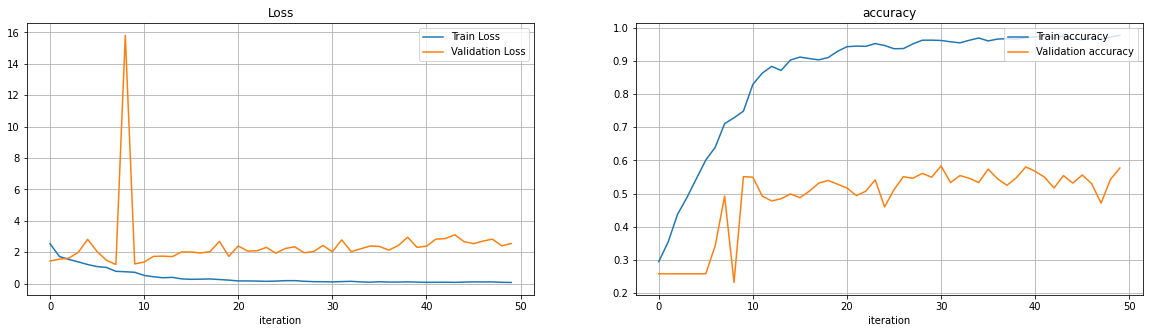

In [15]:
plot_train_val(history.history)

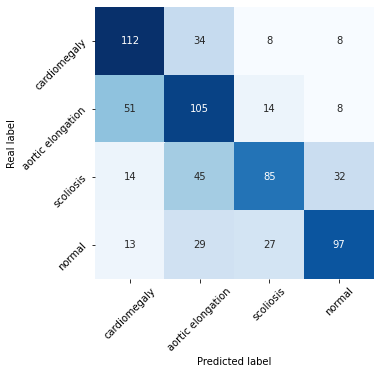

              precision    recall  f1-score   support

           0       0.59      0.69      0.64       162
           1       0.49      0.59      0.54       178
           2       0.63      0.48      0.55       176
           3       0.67      0.58      0.62       166

    accuracy                           0.59       682
   macro avg       0.60      0.59      0.59       682
weighted avg       0.60      0.59      0.58       682



In [16]:
y_pred = model.predict(np.array(data.X_val[:1000]))
plot_conf_mat(np.argmax(y_pred, axis=1), np.argmax(data.y_val[:1000], axis=1), LABELS)

# Train DenseNet201

In [17]:
model = tf.keras.applications.DenseNet201(
    weights=None, input_shape=(224, 224, 1), classes=4)

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
callback = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)

history = model.fit(np.array(data.X_train), np.array(data.y_train), epochs=epochs, batch_size=batch_size,
                    validation_split=val_perc, callbacks=[callback])

Epoch 1/50
87/87 [==============================] - 89s 1s/step - loss: 1.3021 - accuracy: 0.4216 - val_loss: 3.1041 - val_accuracy: 0.2374
Epoch 2/50
87/87 [==============================] - 58s 670ms/step - loss: 1.1705 - accuracy: 0.4668 - val_loss: 2.3903 - val_accuracy: 0.2504
Epoch 3/50
87/87 [==============================] - 74s 848ms/step - loss: 1.0734 - accuracy: 0.5194 - val_loss: 1.8481 - val_accuracy: 0.2650
Epoch 4/50
87/87 [==============================] - 74s 848ms/step - loss: 1.0333 - accuracy: 0.5453 - val_loss: 1.3324 - val_accuracy: 0.4374
Epoch 5/50
87/87 [==============================] - 74s 850ms/step - loss: 0.9868 - accuracy: 0.5717 - val_loss: 1.9931 - val_accuracy: 0.3805
Epoch 6/50
87/87 [==============================] - 74s 847ms/step - loss: 0.9369 - accuracy: 0.6024 - val_loss: 3.1869 - val_accuracy: 0.3967
Epoch 7/50
87/87 [==============================] - 74s 845ms/step - loss: 0.9301 - accuracy: 0.6057 - val_loss: 3.3465 - val_accuracy: 0.3528
Ep

In [19]:
model.save('DenseNet201_class.keras')

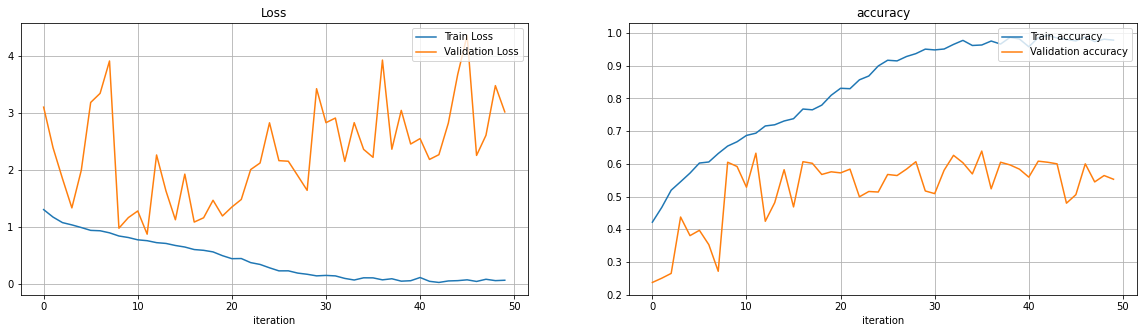

In [20]:
plot_train_val(history.history)

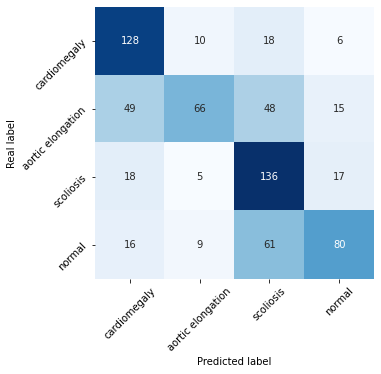

              precision    recall  f1-score   support

           0       0.61      0.79      0.69       162
           1       0.73      0.37      0.49       178
           2       0.52      0.77      0.62       176
           3       0.68      0.48      0.56       166

    accuracy                           0.60       682
   macro avg       0.63      0.60      0.59       682
weighted avg       0.63      0.60      0.59       682



In [21]:
y_pred = model.predict(np.array(data.X_val[:1000]))
plot_conf_mat(np.argmax(y_pred, axis=1), np.argmax(data.y_val[:1000], axis=1), LABELS)

# Train VGG19

In [22]:
model = tf.keras.applications.VGG19(
    weights=None, input_shape=(224, 224, 1), classes=4)

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
callback = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)

history = model.fit(np.array(data.X_train), np.array(data.y_train), epochs=epochs, batch_size=batch_size,
                    validation_split=val_perc, callbacks=[callback])

Epoch 1/50
87/87 [==============================] - 62s 714ms/step - loss: 1.3871 - accuracy: 0.2540 - val_loss: 1.3867 - val_accuracy: 0.2293
Epoch 2/50
87/87 [==============================] - 66s 756ms/step - loss: 1.3866 - accuracy: 0.2486 - val_loss: 1.3868 - val_accuracy: 0.2293
Epoch 3/50
87/87 [==============================] - 67s 768ms/step - loss: 1.3865 - accuracy: 0.2437 - val_loss: 1.3870 - val_accuracy: 0.2585
Epoch 4/50
87/87 [==============================] - 66s 759ms/step - loss: 1.3864 - accuracy: 0.2437 - val_loss: 1.3867 - val_accuracy: 0.2293
Epoch 5/50
87/87 [==============================] - 66s 756ms/step - loss: 1.3863 - accuracy: 0.2531 - val_loss: 1.3868 - val_accuracy: 0.2293
Epoch 6/50
87/87 [==============================] - 65s 752ms/step - loss: 1.3864 - accuracy: 0.2450 - val_loss: 1.3867 - val_accuracy: 0.2293
Epoch 7/50
87/87 [==============================] - 65s 750ms/step - loss: 1.3863 - accuracy: 0.2479 - val_loss: 1.3869 - val_accuracy: 0.2293

In [24]:
model.save('DenseNet201_class.keras')

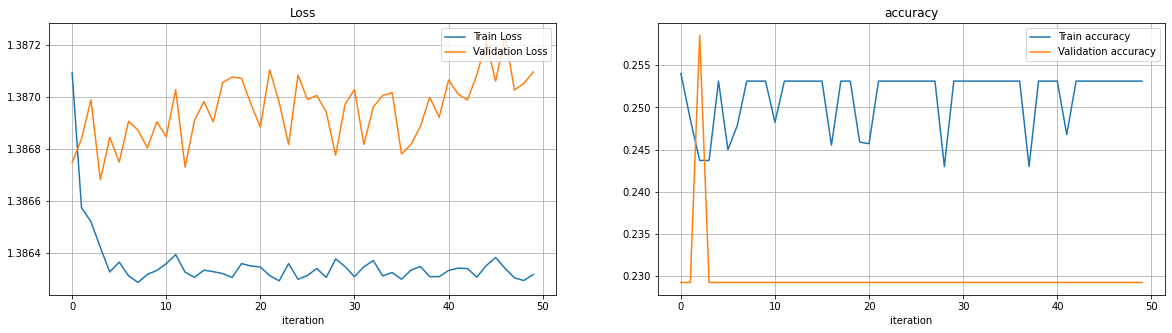

In [25]:
plot_train_val(history.history)

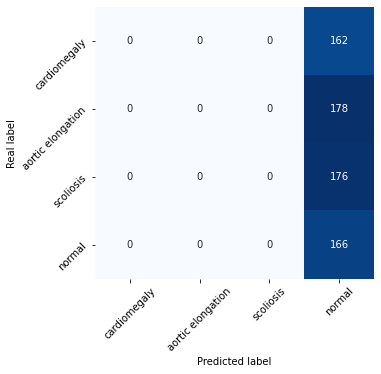

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       162
           1       0.00      0.00      0.00       178
           2       0.00      0.00      0.00       176
           3       0.24      1.00      0.39       166

    accuracy                           0.24       682
   macro avg       0.06      0.25      0.10       682
weighted avg       0.06      0.24      0.10       682



/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
y_pred = model.predict(np.array(data.X_val[:1000]))
plot_conf_mat(np.argmax(y_pred, axis=1), np.argmax(data.y_val[:1000], axis=1), LABELS)

# Train ResNet50

In [27]:
model = tf.keras.applications.ResNet50(
    weights=None, input_shape=(224, 224, 1), classes=4)

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
callback = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)

history = model.fit(np.array(data.X_train), np.array(data.y_train), epochs=epochs, batch_size=batch_size,
                    validation_split=val_perc, callbacks=[callback])

Epoch 1/50
87/87 [==============================] - 46s 524ms/step - loss: 1.4684 - accuracy: 0.3941 - val_loss: 1.9592 - val_accuracy: 0.2569
Epoch 2/50
87/87 [==============================] - 41s 472ms/step - loss: 1.2013 - accuracy: 0.4963 - val_loss: 5.1419 - val_accuracy: 0.2585
Epoch 3/50
87/87 [==============================] - 41s 473ms/step - loss: 1.0929 - accuracy: 0.5350 - val_loss: 1.8451 - val_accuracy: 0.2569
Epoch 4/50
87/87 [==============================] - 41s 475ms/step - loss: 1.0034 - accuracy: 0.5753 - val_loss: 1.4750 - val_accuracy: 0.4179
Epoch 5/50
87/87 [==============================] - 41s 476ms/step - loss: 0.9443 - accuracy: 0.6071 - val_loss: 1.1321 - val_accuracy: 0.4911
Epoch 6/50
87/87 [==============================] - 42s 477ms/step - loss: 0.9030 - accuracy: 0.6268 - val_loss: 1.2951 - val_accuracy: 0.5285
Epoch 7/50
87/87 [==============================] - 41s 476ms/step - loss: 0.8636 - accuracy: 0.6420 - val_loss: 1.5557 - val_accuracy: 0.4000

In [29]:
model.save('DenseNet201_class.keras')

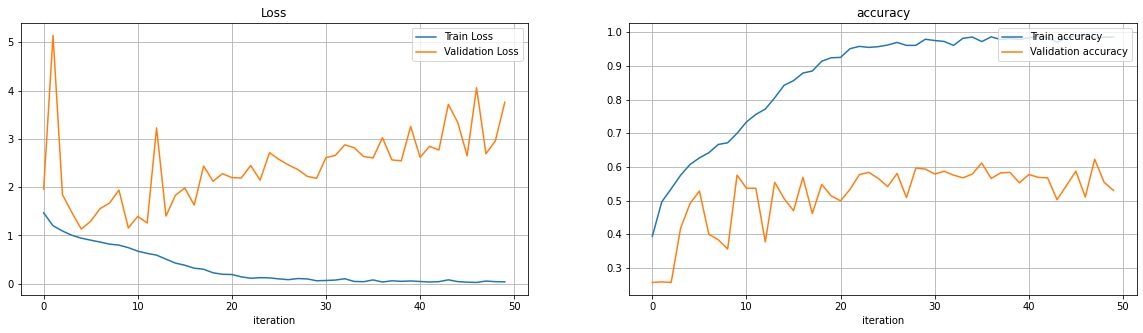

In [30]:
plot_train_val(history.history)

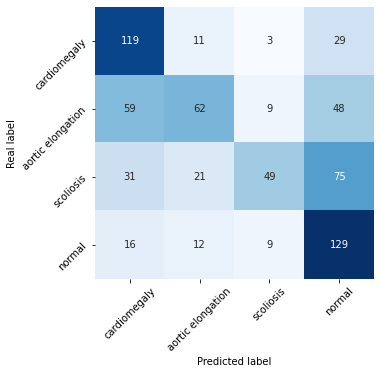

              precision    recall  f1-score   support

           0       0.53      0.73      0.61       162
           1       0.58      0.35      0.44       178
           2       0.70      0.28      0.40       176
           3       0.46      0.78      0.58       166

    accuracy                           0.53       682
   macro avg       0.57      0.53      0.51       682
weighted avg       0.57      0.53      0.50       682



In [31]:
y_pred = model.predict(np.array(data.X_val[:1000]))
plot_conf_mat(np.argmax(y_pred, axis=1), np.argmax(data.y_val[:1000], axis=1), LABELS)

# Results with 10 iterations

In [33]:
n_imgs = 1000
n_it = 10

## MOCVAE

In [42]:
models_base_path = 'results_padchest_'
version = 2

accuracy_mocvae = []
f1_score_mocvae = []
recall_mocvae = []
precision_mocvae = []

for i in range(1,n_it+1):
    model_path  = models_base_path + 'v' + str(version)*i + "_MOCVAE/"
    encoder = load_model(model_path + 'models/e_best_encoder.h5', custom_objects={'sampling': sampling})
    classifier = load_model(model_path + 'models/e_best_classifier.h5', custom_objects={'sampling': sampling})

    lat_space = encoder.predict(data.X_val[:n_imgs])
    y_pred = classifier.predict(lat_space)

    y_pred = np.argmax(y_pred, axis=1)
    y_val = np.argmax(data.y_val[:n_imgs], axis=1)

    report = classification_report(y_val, y_pred, output_dict=True)
    accuracy_mocvae.append(report['accuracy'])
    f1_score_mocvae.append(report['macro avg']['f1-score'])
    recall_mocvae.append(report['macro avg']['recall'])
    precision_mocvae.append(report['macro avg']['precision'])

print("-"*5, 'MOCVAE', "-"*5)
print("accuracy: " + str(np.mean(accuracy_mocvae)))
print("f1_score: " + str(np.mean(f1_score_mocvae)))
print("recall: " + str(np.mean(recall_mocvae)))
print("precision: " + str(np.mean(precision_mocvae)))

----- MOCVAE -----
accuracy: 0.6085043988269795
f1_score: 0.6060509305787509
recall: 0.6113027619785691
precision: 0.6202824630889432


## EfficientNetB0

In [34]:
accuracy_efficientnet = []
f1_score_efficientnet = []
recall_efficientnet = []
precision_efficientnet = []

for i in range(1,n_it+1):
    print('It:', str(i), datetime.now())
    model_efficientnet = tf.keras.applications.EfficientNetB0(
        weights=None, input_shape=(224, 224, 1), classes=4)
    model_efficientnet.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)
    history = model_efficientnet.fit(np.array(data.X_train), np.array(data.y_train), epochs=epochs, batch_size=batch_size,
                        validation_split=val_perc, callbacks=[callback], verbose=0)

    y_pred = np.argmax(model_efficientnet.predict(np.array(data.X_val[:n_imgs])), axis=1)
    y_val = np.argmax(data.y_val[:n_imgs], axis=1)

    report = classification_report(y_val, y_pred, output_dict=True)
    accuracy_efficientnet.append(report['accuracy'])
    f1_score_efficientnet.append(report['macro avg']['f1-score'])
    recall_efficientnet.append(report['macro avg']['recall'])
    precision_efficientnet.append(report['macro avg']['precision'])

print("-"*5, 'EfficientNetB0', "-"*5)
print("accuracy: " + str(np.mean(accuracy_efficientnet)))
print("f1_score: " + str(np.mean(f1_score_efficientnet)))
print("recall: " + str(np.mean(recall_efficientnet)))
print("precision: " + str(np.mean(precision_efficientnet)))

It: 1 2024-05-21 14:12:26.056989
It: 2 2024-05-21 14:54:32.631802
It: 3 2024-05-21 15:35:46.812584
It: 4 2024-05-21 16:17:16.107513
It: 5 2024-05-21 16:58:31.048969
It: 6 2024-05-21 17:40:19.771232
It: 7 2024-05-21 18:21:47.295583
It: 8 2024-05-21 19:03:12.542810
It: 9 2024-05-21 19:43:27.778839
It: 10 2024-05-21 20:25:11.315699
----- EfficientNetB0 -----
accuracy: 0.5467741935483871
f1_score: 0.5439395370898725
recall: 0.5480254984584805
precision: 0.5609631860289053


## DenseNet201

In [35]:
accuracy_densenet = []
f1_score_densenet = []
recall_densenet = []
precision_densenet = []

for i in range(1,n_it+1):
    print('It:', str(i), datetime.now())
    model_densenet = tf.keras.applications.DenseNet201(
        weights=None, input_shape=(224, 224, 1), classes=4)
    model_densenet.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)
    history = model_densenet.fit(np.array(data.X_train), np.array(data.y_train), epochs=epochs, batch_size=batch_size,
                        validation_split=val_perc, callbacks=[callback], verbose=0)

    y_pred = np.argmax(model_densenet.predict(np.array(data.X_val[:n_imgs])), axis=1)
    y_val = np.argmax(data.y_val[:n_imgs], axis=1)

    report = classification_report(y_val, y_pred, output_dict=True)
    accuracy_densenet.append(report['accuracy'])
    f1_score_densenet.append(report['macro avg']['f1-score'])
    recall_densenet.append(report['macro avg']['recall'])
    precision_densenet.append(report['macro avg']['precision'])

print("-"*5, 'DenseNet201', "-"*5)
print("accuracy: " + str(np.mean(accuracy_densenet)))
print("f1_score: " + str(np.mean(f1_score_densenet)))
print("recall: " + str(np.mean(recall_densenet)))
print("precision: " + str(np.mean(precision_densenet)))

It: 1 2024-05-21 21:06:30.555780
It: 2 2024-05-21 22:05:24.104012
It: 3 2024-05-21 23:04:48.890939
It: 4 2024-05-22 00:05:16.707932
It: 5 2024-05-22 01:05:35.999971
It: 6 2024-05-22 02:05:37.943906
It: 7 2024-05-22 03:04:54.294874
It: 8 2024-05-22 04:04:31.403918
It: 9 2024-05-22 05:04:17.115755
It: 10 2024-05-22 06:03:51.045379
----- DenseNet201 -----
accuracy: 0.5804985337243401
f1_score: 0.5657661644709354
recall: 0.5827149583086251
precision: 0.6319759896682805


## VGG19

In [36]:
accuracy_vgg19 = []
f1_score_vgg19 = []
recall_vgg19 = []
precision_vgg19 = []

for i in range(1,n_it+1):
    print('It:', str(i), datetime.now())
    model_vgg19 = tf.keras.applications.VGG19(
        weights=None, input_shape=(224, 224, 1), classes=4)
    model_vgg19.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)
    history = model_vgg19.fit(np.array(data.X_train), np.array(data.y_train), epochs=epochs, batch_size=batch_size,
                        validation_split=val_perc, callbacks=[callback], verbose=0)

    y_pred = np.argmax(model_vgg19.predict(np.array(data.X_val[:n_imgs])), axis=1)
    y_val = np.argmax(data.y_val[:n_imgs], axis=1)

    report = classification_report(y_val, y_pred, output_dict=True)
    accuracy_vgg19.append(report['accuracy'])
    f1_score_vgg19.append(report['macro avg']['f1-score'])
    recall_vgg19.append(report['macro avg']['recall'])
    precision_vgg19.append(report['macro avg']['precision'])
    
print("-"*5, 'VGG19', "-"*5)
print("accuracy: " + str(np.mean(accuracy_vgg19)))
print("f1_score: " + str(np.mean(f1_score_vgg19)))
print("recall: " + str(np.mean(recall_vgg19)))
print("precision: " + str(np.mean(precision_vgg19)))

It: 1 2024-05-22 07:01:48.395203
It: 2 2024-05-22 07:53:04.883111
It: 3 2024-05-22 08:45:37.047473
It: 4 2024-05-22 09:37:59.471243
It: 5 2024-05-22 10:30:06.810824
It: 6 2024-05-22 11:22:31.135508
It: 7 2024-05-22 12:14:59.212106
It: 8 2024-05-22 13:06:49.775361
It: 9 2024-05-22 13:57:07.039171
It: 10 2024-05-22 14:49:25.947422
----- VGG19 -----
accuracy: 0.24340175953079174
f1_score: 0.09787735849056603
recall: 0.25
precision: 0.060850439882697935


## ResNet50

In [37]:
accuracy_resnet = []
f1_score_resnet = []
recall_resnet = []
precision_resnet = []

for i in range(1,n_it+1):
    print('It:', str(i), datetime.now())
    model_resnet = tf.keras.applications.ResNet50(
        weights=None, input_shape=(224, 224, 1), classes=4)
    model_resnet.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)
    history = model_resnet.fit(np.array(data.X_train), np.array(data.y_train), epochs=epochs, batch_size=batch_size,
                        validation_split=val_perc, callbacks=[callback], verbose=0)

    y_pred = np.argmax(model_resnet.predict(np.array(data.X_val[:n_imgs])), axis=1)
    y_val = np.argmax(data.y_val[:n_imgs], axis=1)

    report = classification_report(y_val, y_pred, output_dict=True)
    accuracy_resnet.append(report['accuracy'])
    f1_score_resnet.append(report['macro avg']['f1-score'])
    recall_resnet.append(report['macro avg']['recall'])
    precision_resnet.append(report['macro avg']['precision'])
    
print("-"*5, 'ResNet50', "-"*5)
print("accuracy: " + str(np.mean(accuracy_resnet)))
print("f1_score: " + str(np.mean(f1_score_resnet)))
print("recall: " + str(np.mean(recall_resnet)))
print("precision: " + str(np.mean(precision_resnet)))

It: 1 2024-05-22 15:41:23.539613
It: 2 2024-05-22 16:14:33.844733
It: 3 2024-05-22 16:48:22.639909
It: 4 2024-05-22 17:21:05.316586
It: 5 2024-05-22 17:54:50.139484
It: 6 2024-05-22 18:28:23.775739
It: 7 2024-05-22 19:01:39.674117
It: 8 2024-05-22 19:34:33.907002
It: 9 2024-05-22 20:08:01.630956
It: 10 2024-05-22 20:41:25.646925
----- ResNet50 -----
accuracy: 0.5602639296187684
f1_score: 0.554655755649202
recall: 0.5604677826332
precision: 0.5845933563985801


## Summary of the results

In [89]:
df = pd.DataFrame(index=['MOCVAE', 'EfficientNetB0', 'DenseNet201', 'VGG19', 'ResNet50'],
                  columns=['accuracy', 'f1-score', 'recall', 'precision'])

df.at['MOCVAE', 'accuracy'] = "{:.2f}".format(np.mean(accuracy_mocvae)) + '$\pm$' + "{:.2f}".format(np.std(accuracy_mocvae))
df.at['EfficientNetB0', 'accuracy'] = "{:.2f}".format(np.mean(accuracy_efficientnet)) + '$\pm$' + "{:.2f}".format(np.std(accuracy_efficientnet))
df.at['DenseNet201', 'accuracy'] = "{:.2f}".format(np.mean(accuracy_densenet)) + '$\pm$' + "{:.2f}".format(np.std(accuracy_densenet))
df.at['VGG19', 'accuracy'] = "{:.2f}".format(np.mean(accuracy_vgg19)) + '$\pm$' + "{:.2f}".format(np.std(accuracy_vgg19))
df.at['ResNet50', 'accuracy'] = "{:.2f}".format(np.mean(accuracy_resnet)) + '$\pm$' + "{:.2f}".format(np.std(accuracy_resnet))

df.at['MOCVAE', 'f1-score'] = "{:.2f}".format(np.mean(f1_score_mocvae)) + '$\pm$' + "{:.2f}".format(np.std(f1_score_mocvae))
df.at['EfficientNetB0', 'f1-score'] = "{:.2f}".format(np.mean(f1_score_efficientnet)) + '$\pm$' + "{:.2f}".format(np.std(f1_score_efficientnet))
df.at['DenseNet201', 'f1-score'] = "{:.2f}".format(np.mean(f1_score_densenet)) + '$\pm$' + "{:.2f}".format(np.std(f1_score_densenet))
df.at['VGG19', 'f1-score'] = "{:.2f}".format(np.mean(f1_score_vgg19)) + '$\pm$' + "{:.2f}".format(np.std(f1_score_vgg19))
df.at['ResNet50', 'f1-score'] = "{:.2f}".format(np.mean(f1_score_resnet)) + '$\pm$' + "{:.2f}".format(np.std(f1_score_resnet))

df.at['MOCVAE', 'recall'] = "{:.2f}".format(np.mean(recall_mocvae)) + '$\pm$' + "{:.2f}".format(np.std(recall_mocvae))
df.at['EfficientNetB0', 'recall'] = "{:.2f}".format(np.mean(recall_efficientnet)) + '$\pm$' + "{:.2f}".format(np.std(recall_efficientnet))
df.at['DenseNet201', 'recall'] = "{:.2f}".format(np.mean(recall_densenet)) + '$\pm$' + "{:.2f}".format(np.std(recall_densenet))
df.at['VGG19', 'recall'] = "{:.2f}".format(np.mean(recall_vgg19)) + '$\pm$' + "{:.2f}".format(np.std(recall_vgg19))
df.at['ResNet50', 'recall'] = "{:.2f}".format(np.mean(recall_resnet)) + '$\pm$' + "{:.2f}".format(np.std(recall_resnet))

df.at['MOCVAE', 'precision'] = "{:.2f}".format(np.mean(precision_mocvae)) + '$\pm$' + "{:.2f}".format(np.std(precision_mocvae))
df.at['EfficientNetB0', 'precision'] = "{:.2f}".format(np.mean(precision_efficientnet)) + '$\pm$' + "{:.2f}".format(np.std(precision_efficientnet))
df.at['DenseNet201', 'precision'] = "{:.2f}".format(np.mean(precision_densenet)) + '$\pm$' + "{:.2f}".format(np.std(precision_densenet))
df.at['VGG19', 'precision'] = "{:.2f}".format(np.mean(precision_vgg19)) + '$\pm$' + "{:.2f}".format(np.std(precision_vgg19))
df.at['ResNet50', 'precision'] = "{:.2f}".format(np.mean(precision_resnet)) + '$\pm$' + "{:.2f}".format(np.std(precision_resnet))

In [90]:
pd.set_option('display.max_colwidth', None)
df.head(5)

,accuracy,f1-score,recall,precision
MOCVAE,0.61$\pm$0.01,0.61$\pm$0.02,0.61$\pm$0.01,0.62$\pm$0.01
EfficientNetB0,0.55$\pm$0.03,0.54$\pm$0.03,0.55$\pm$0.03,0.56$\pm$0.03
DenseNet201,0.58$\pm$0.07,0.57$\pm$0.09,0.58$\pm$0.07,0.63$\pm$0.03
VGG19,0.24$\pm$0.00,0.10$\pm$0.00,0.25$\pm$0.00,0.06$\pm$0.00
ResNet50,0.56$\pm$0.02,0.55$\pm$0.03,0.56$\pm$0.02,0.58$\pm$0.02


In [91]:
from tabulate import tabulate

print(tabulate(df, tablefmt="latex_raw"))

\begin{tabular}{lllll}
\hline
 MOCVAE         & 0.61$\pm$0.01 & 0.61$\pm$0.02 & 0.61$\pm$0.01 & 0.62$\pm$0.01 \\
 EfficientNetB0 & 0.55$\pm$0.03 & 0.54$\pm$0.03 & 0.55$\pm$0.03 & 0.56$\pm$0.03 \\
 DenseNet201    & 0.58$\pm$0.07 & 0.57$\pm$0.09 & 0.58$\pm$0.07 & 0.63$\pm$0.03 \\
 VGG19          & 0.24$\pm$0.00 & 0.10$\pm$0.00 & 0.25$\pm$0.00 & 0.06$\pm$0.00 \\
 ResNet50       & 0.56$\pm$0.02 & 0.55$\pm$0.03 & 0.56$\pm$0.02 & 0.58$\pm$0.02 \\
\hline
\end{tabular}


### Wilcoxon rank-sum

In [98]:
from scipy.stats import ranksums

print("\n-----Accuracy-----\n")

stat, p_value = ranksums(accuracy_mocvae, accuracy_efficientnet)
print(f"MOCVAE - EfficientNetB0: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(accuracy_mocvae, accuracy_densenet)
print(f"MOCVAE - DenseNet201: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(accuracy_mocvae, accuracy_vgg19)
print(f"MOCVAE - VGG19: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(accuracy_mocvae, accuracy_resnet)
print(f"MOCVAE - ResNet50: statistic={stat:.4f}, p-value={p_value:.4f}")

print("\n-----F1 score-----\n")

stat, p_value = ranksums(f1_score_mocvae, f1_score_efficientnet)
print(f"MOCVAE - EfficientNetB0: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(f1_score_mocvae, f1_score_densenet)
print(f"MOCVAE - DenseNet201: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(f1_score_mocvae, f1_score_vgg19)
print(f"MOCVAE - VGG19: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(f1_score_mocvae, f1_score_resnet)
print(f"MOCVAE - ResNet50: statistic={stat:.4f}, p-value={p_value:.4f}")

print("\n-----Recall-----\n")

stat, p_value = ranksums(recall_mocvae, recall_efficientnet)
print(f"MOCVAE - EfficientNetB0: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(recall_mocvae, recall_densenet)
print(f"MOCVAE - DenseNet201: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(recall_mocvae, recall_vgg19)
print(f"MOCVAE - VGG19: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(recall_mocvae, recall_resnet)
print(f"MOCVAE - ResNet50: statistic={stat:.4f}, p-value={p_value:.4f}")

print("\n-----Precision-----\n")

stat, p_value = ranksums(precision_mocvae, precision_efficientnet)
print(f"MOCVAE - EfficientNetB0: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(precision_mocvae, precision_densenet)
print(f"MOCVAE - DenseNet201: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(precision_mocvae, precision_vgg19)
print(f"MOCVAE - VGG19: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(precision_mocvae, precision_resnet)
print(f"MOCVAE - ResNet50: statistic={stat:.4f}, p-value={p_value:.4f}")


-----Accuracy-----

MOCVAE - EfficientNetB0: statistic=3.7796, p-value=0.0002
MOCVAE - DenseNet201: statistic=-0.0378, p-value=0.9698
MOCVAE - VGG19: statistic=3.7796, p-value=0.0002
MOCVAE - ResNet50: statistic=3.2505, p-value=0.0012

-----F1 score-----

MOCVAE - EfficientNetB0: statistic=3.7796, p-value=0.0002
MOCVAE - DenseNet201: statistic=-0.0756, p-value=0.9397
MOCVAE - VGG19: statistic=3.7796, p-value=0.0002
MOCVAE - ResNet50: statistic=3.3261, p-value=0.0009

-----Recall-----

MOCVAE - EfficientNetB0: statistic=3.7796, p-value=0.0002
MOCVAE - DenseNet201: statistic=0.1512, p-value=0.8798
MOCVAE - VGG19: statistic=3.7796, p-value=0.0002
MOCVAE - ResNet50: statistic=3.4017, p-value=0.0007

-----Precision-----

MOCVAE - EfficientNetB0: statistic=3.7041, p-value=0.0002
MOCVAE - DenseNet201: statistic=-1.5119, p-value=0.1306
MOCVAE - VGG19: statistic=3.7796, p-value=0.0002
MOCVAE - ResNet50: statistic=3.0237, p-value=0.0025


### All values

In [81]:
#Security values
model_names = ['MOCVAE', 'EfficientNetB0', 'DenseNet201', 'VGG19', 'ResNet50']

print("\n-----Accuracies-----\n")
for i, acc in enumerate([accuracy_mocvae, accuracy_efficientnet, accuracy_densenet, accuracy_vgg19, accuracy_resnet]):
    print(model_names[i])
    print(acc)

print("\n-----f1-scores-----\n")
for i, f1 in enumerate([f1_score_mocvae, f1_score_efficientnet, f1_score_densenet, f1_score_vgg19, f1_score_resnet]):
    print(model_names[i])
    print(f1)

print("\n-----Recall-----\n")
for i, rec in enumerate([recall_mocvae, recall_efficientnet, recall_densenet, recall_vgg19, recall_resnet]):
    print(model_names[i])
    print(rec)

print("\n-----Precisions-----\n")
for i, pre in enumerate([precision_mocvae, precision_efficientnet, precision_densenet, precision_vgg19, precision_resnet]):
    print(model_names[i])
    print(pre)


-----Accuracies-----

MOCVAE
[0.6114369501466276, 0.624633431085044, 0.6041055718475073, 0.6187683284457478, 0.6363636363636364, 0.5967741935483871, 0.6055718475073314, 0.5953079178885631, 0.6011730205278593, 0.5909090909090909]
EfficientNetB0
[0.5410557184750733, 0.5498533724340176, 0.49853372434017595, 0.5439882697947214, 0.5410557184750733, 0.5278592375366569, 0.5850439882697948, 0.5205278592375366, 0.5791788856304986, 0.5806451612903226]
DenseNet201
[0.5865102639296188, 0.6319648093841642, 0.626099706744868, 0.6202346041055719, 0.6231671554252199, 0.4970674486803519, 0.4178885630498534, 0.6290322580645161, 0.5542521994134897, 0.6187683284457478]
VGG19
[0.2434017595307918, 0.2434017595307918, 0.2434017595307918, 0.2434017595307918, 0.2434017595307918, 0.2434017595307918, 0.2434017595307918, 0.2434017595307918, 0.2434017595307918, 0.2434017595307918]
ResNet50
[0.5351906158357771, 0.5439882697947214, 0.5645161290322581, 0.6129032258064516, 0.5498533724340176, 0.5747800586510264, 0.52